# Time Series Analysis with LightGBM

## Imports

In [477]:
# !pip install ucimlrepo --quiet
import pandas as pd
import numpy as np
import ucimlrepo
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
from datetime import datetime, timedelta

## Load Data

In [39]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
appliances_energy_prediction = fetch_ucirepo(id=374)

# data (as pandas dataframes)
X = appliances_energy_prediction.data.features
y = appliances_energy_prediction.data.targets

In [107]:
# To Pandas DataFrame
df = pd.concat([X, y], axis=1)
df['date'] = df['date'].apply(lambda x: x[:10] + ' ' + x[11:])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 07:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
2016-01-11 07:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2016-01-11 07:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
2016-01-11 07:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390,50
2016-01-11 07:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [108]:
# Resample to hour
df = df.resample('h').sum()
df.index.freq = 'h'

## Functions

In [682]:
class TSA:
  def __init__(self):
    pass


  def load_data(self, file_path):
    """Loads data from a CSV file and returns a Pandas DataFrame."""
    try:
        df = pd.read_csv(file_path, index_col='Date', parse_dates=['Date'])
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None


  # Preprocess the data and engineer features
  def preprocess_data(self, df):
    """Preprocesses the data and engineers time-based features."""
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Hour'] = df.index.hour


    # Lagged features (example: sales from previous 24 hours)
    for i in range(1, 24):
      df[f'{i}_ConsumptionLag'] = df['Appliances'].shift(i)

    # Drop rows with NaN values after lagging
    df = df.dropna()

    return df


  # Split the data into training and testing sets
  def split_data(self, df, test_size=0.2):
      """Splits the data into training and testing sets."""
      X = df.drop('Appliances', axis=1)
      y = df['Appliances']
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
      return X_train, X_test, y_train, y_test


  # Train the LightGBM model
  def train_model(self, X_train, y_train):
      """Trains a LightGBM model on the training data."""
      lgb_train = lgb.Dataset(X_train, y_train)
      lgb_eval = lgb.Dataset(X_train, y_train, reference=lgb_train)
      params = {
          'objective': 'regression',
          'metric': 'mape',
          'boosting_type': 'gbdt',
          'learning_rate': 0.05,
          'num_leaves': 15,
          'max_depth': 15,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'verbose': -1,
      }
      gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=500,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.early_stopping(stopping_rounds=10)])
      return gbm


  def preprocess_forecast(self, df):
    """Preprocesses the data and engineers time-based features."""

    # Drop columns that we don't have at the time of the forecast
    # Keep what we will have at the prediction time.
    cols = ['Appliances', 'DayOfWeek', 'Month', 'Quarter', 'Year',
       'DayOfYear', 'WeekOfYear', 'ConsumptionLag_1',
       'ConsumptionLag_2', 'ConsumptionLag_3', 'ConsumptionLag_4',
       'ConsumptionLag_5', 'ConsumptionLag_6', 'ConsumptionLag_7',
       'ConsumptionLag_8', 'ConsumptionLag_9', 'ConsumptionLag_10',
       'ConsumptionLag_11', 'ConsumptionLag_12', 'ConsumptionLag_13',
       'ConsumptionLag_14', 'ConsumptionLag_15', 'ConsumptionLag_16',
       'ConsumptionLag_17', 'ConsumptionLag_18', 'ConsumptionLag_19',
       'ConsumptionLag_20', 'ConsumptionLag_21', 'ConsumptionLag_22',
       'ConsumptionLag_23', 'Hour']

    df = df[cols]

    return df



  # Predict
  def model_predict(self, model, X):
      """Evaluates the model on the test data."""
      y_pred = model.predict(X, num_iteration=model.best_iteration)
      return y_pred


  # Evaluate the model
  def evaluate_model(self, model, X_test, y_test):
      """Evaluates the model on the test data."""
      y_pred = model.predict(X_test, num_iteration=model.best_iteration)
      mape = mean_absolute_percentage_error(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)
      print(f'MAE: {mae}')
      print(f'MAPE: {mape}')
      return y_pred


  # Visualize the predictions
  def visualize_predictions(self, y_test, y_pred):
      """Visualizes the predictions against the actual values."""
      plt.figure(figsize=(19, 6))
      plt.plot(y_test.index, y_test.values, label='Actual', color='darkgray', linewidth=3)
      plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.5, linestyle='--',color='green')
      plt.xlabel('Date')
      plt.ylabel('Consumption')
      plt.title('Consumption Prediction')
      plt.legend()
      plt.grid(True)
      plt.show()

## Modeling

In [683]:
# Instantiate
tsa = TSA()

In [684]:
# Preprocess Data
prep = tsa.preprocess_data(df)

In [671]:
# Split Data
X_train, X_test, y_train, y_test = tsa.split_data(prep)

In [672]:
# Train Model
model = tsa.train_model(X_train, y_train)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's mape: 0.13978


In [673]:
# Evaluate Model
y_pred = tsa.evaluate_model(model, X_test, y_test)

MAE: 1.9963281184236228
MAPE: 484489077411758.3


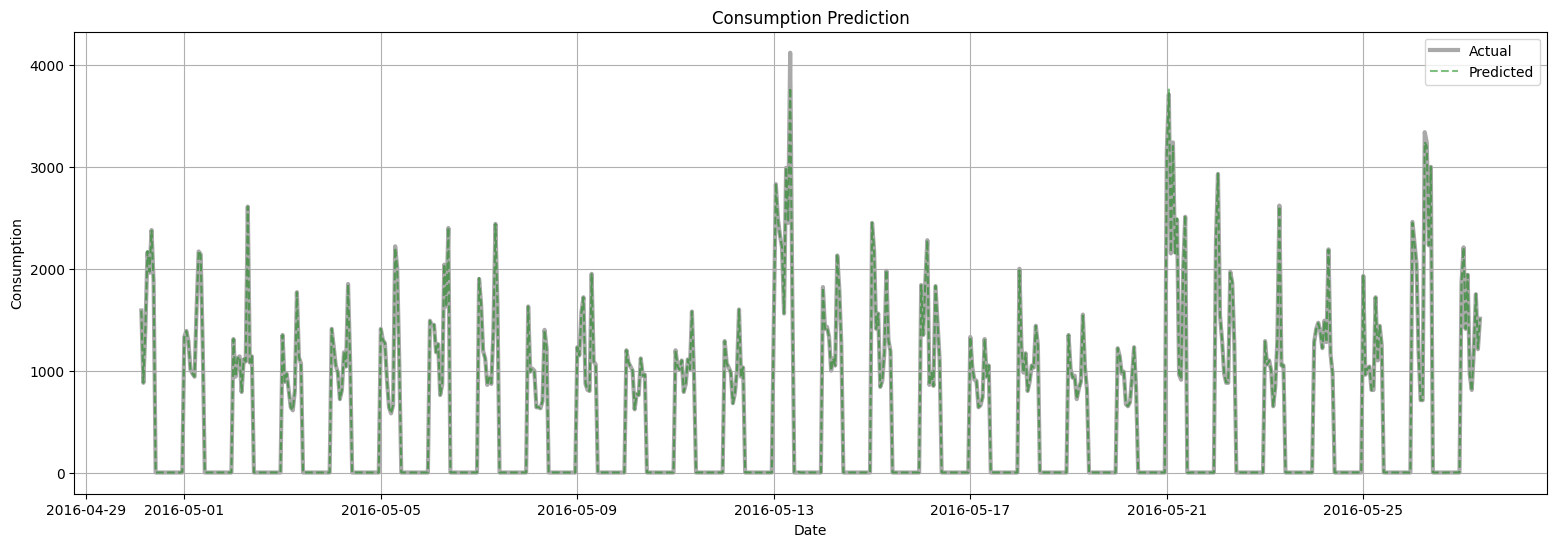

In [674]:
# Visualize
tsa.visualize_predictions(y_test, y_pred)

In [675]:
# Eval dataframe
df_eval= pd.DataFrame({
    'Actual': y_test,
    'Pred': y_pred.astype(int),
    'diff': y_test - y_pred.astype(int),
    'mape(int%)': np.round(100*abs(y_test - y_pred)/y_test,2)
})

# Clean zeroes: Everytime we see a "actual == 0", the division by 0 gives us error.
# This is just a small adjustment to help calculations
df_eval['mape(int%)'] = np.select(condlist=[(df_eval['Actual'] == 0) & (df_eval['Pred'] == 0),
                                      (df_eval['Actual'] == 0) & (df_eval['Pred']!= 0)],
                            choicelist= [0,100], default=df_eval['mape(int%)'])
df_eval

,Actual,Pred,diff,mape(int%)
date,,,,
2016-04-30 03:00:00,1590,1589,1,0.03
2016-04-30 04:00:00,880,880,0,0.09
2016-04-30 05:00:00,1420,1418,2,0.07
2016-04-30 06:00:00,2160,2173,-13,0.61
2016-04-30 07:00:00,1960,1971,-11,0.56
...,...,...,...,...
2016-05-27 05:00:00,810,800,10,1.22
2016-05-27 06:00:00,1190,1199,-9,0.81
2016-05-27 07:00:00,1750,1752,-2,0.17


In [676]:
df_eval.mean()

,0
Actual,572.839695
Pred,572.006107
diff,0.833588
mape(int%),1.465053


## Estimate Future Dates - FORECAST

In [686]:
def future_dates(df):
  '''
  Create the next step in the future for forecast prediction.
  '''

  # Predict into the future using the model
  future_dates = pd.date_range(start=df.index[-1] + timedelta(hours=1), periods=1, freq='h')
  future_df = pd.DataFrame(index=future_dates, columns=prep_forecast.columns)

  # Add columns
  future_df['DayOfWeek'] = future_df.index.dayofweek
  future_df['Month'] = future_df.index.month
  future_df['Quarter'] = future_df.index.quarter
  future_df['Year'] = future_df.index.year
  future_df['DayOfYear'] = future_df.index.dayofyear
  future_df['WeekOfYear'] = future_df.index.isocalendar().week
  future_df['Hour'] = future_df.index.hour

  lags = ['ConsumptionLag_1', 'ConsumptionLag_2', 'ConsumptionLag_3', 'ConsumptionLag_4',
          'ConsumptionLag_5', 'ConsumptionLag_6', 'ConsumptionLag_7', 'ConsumptionLag_8', 'ConsumptionLag_9',
          'ConsumptionLag_10', 'ConsumptionLag_11', 'ConsumptionLag_12', 'ConsumptionLag_13', 'ConsumptionLag_14',
          'ConsumptionLag_15', 'ConsumptionLag_16','ConsumptionLag_17', 'ConsumptionLag_18', 'ConsumptionLag_19',
        'ConsumptionLag_20', 'ConsumptionLag_21', 'ConsumptionLag_22', 'ConsumptionLag_23']

  # Lagged features (from previous 24 hours)
  latest24h = df['Appliances'].tail(25).values[::-1]

  for n,c in enumerate(future_df[lags].columns):
    future_df[c] = latest24h[n]

  return future_df

In [704]:
# Preprocessed Data for Forecast
prep_forecast = tsa.preprocess_forecast(prep)

# Retrain model with less features
model2 = tsa.train_model(prep_forecast.drop('Appliances', axis=1),
                         prep_forecast['Appliances'])

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	valid_0's mape: 4.81142


In [706]:
# Estimating for 48 hours ahead.

for fcast in range(48):
  # Create one future hour observation
  future_df = future_dates(prep_forecast)

  # Predict
  prediction = tsa.model_predict(model2, future_df.drop('Appliances', axis=1))
  print(f'The prediction for the next hour is {prediction[0]}')

  # Add the prediction to the data
  future_df['Appliances'] = prediction[0].astype(int)
  future_df

  # Append to the preprocessed dataset
  prep_forecast = pd.concat([prep_forecast, future_df])

The prediction for the next hour is 28.10752570926865
The prediction for the next hour is 16.023353705019574
The prediction for the next hour is 9.763636670146289
The prediction for the next hour is 9.763636670146289
The prediction for the next hour is 10.515582079654061
The prediction for the next hour is 9.773684326759218
The prediction for the next hour is 9.773684326759218
The prediction for the next hour is 9.773684326759218
The prediction for the next hour is 8.551310421688177
The prediction for the next hour is 8.551310421688177
The prediction for the next hour is 9.773684326759218
The prediction for the next hour is 8.551310421688177
The prediction for the next hour is 8.690080306616549
The prediction for the next hour is 20.15990444689697
The prediction for the next hour is 1836.6120167829897
The prediction for the next hour is 1640.9577369455353
The prediction for the next hour is 1544.3186709544264
The prediction for the next hour is 1338.625906364584
The prediction for the 

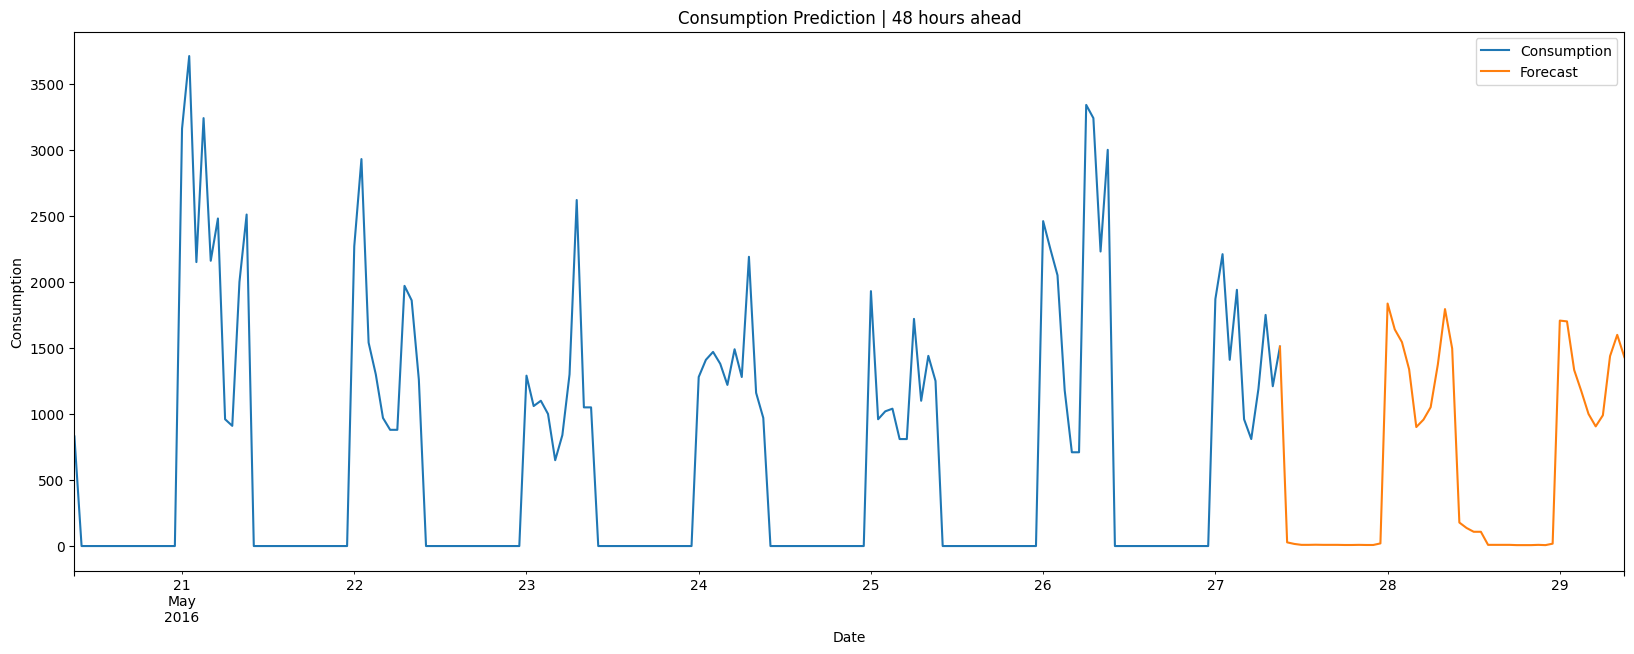

In [716]:
# Plot
prep_forecast["2016-05-20 09:00:00":"2016-05-27 09:00:00"]['Appliances'].plot(label='Consumption',figsize=(20,7))
prep_forecast["2016-05-27 09:00:00":]['Appliances'].plot(label= 'Forecast', figsize=(20,7))
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Consumption Prediction | 48 hours ahead')
plt.legend()
plt.show()

In [714]:
prep_forecast.tail(50)

,Appliances,DayOfWeek,Month,Quarter,Year,DayOfYear,WeekOfYear,ConsumptionLag_1,ConsumptionLag_2,ConsumptionLag_3,ConsumptionLag_4,ConsumptionLag_5,ConsumptionLag_6,ConsumptionLag_7,ConsumptionLag_8,ConsumptionLag_9,ConsumptionLag_10,ConsumptionLag_11,ConsumptionLag_12,ConsumptionLag_13,ConsumptionLag_14,ConsumptionLag_15,ConsumptionLag_16,ConsumptionLag_17,ConsumptionLag_18,ConsumptionLag_19,ConsumptionLag_20,ConsumptionLag_21,ConsumptionLag_22,ConsumptionLag_23,Hour
2016-05-27 08:00:00,1210,4,5,2,2016,148,21,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,8
2016-05-27 09:00:00,1510,4,5,2,2016,148,21,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2016-05-27 10:00:00,28,4,5,2,2016,148,21,1510.0,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
2016-05-27 11:00:00,16,4,5,2,2016,148,21,28.0,1510.0,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2016-05-27 12:00:00,9,4,5,2,2016,148,21,16.0,28.0,1510.0,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
2016-05-27 13:00:00,9,4,5,2,2016,148,21,9.0,16.0,28.0,1510.0,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
2016-05-27 14:00:00,10,4,5,2,2016,148,21,9.0,9.0,16.0,28.0,1510.0,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
2016-05-27 15:00:00,9,4,5,2,2016,148,21,10.0,9.0,9.0,16.0,28.0,1510.0,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
2016-05-27 16:00:00,9,4,5,2,2016,148,21,9.0,10.0,9.0,9.0,16.0,28.0,1510.0,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
2016-05-27 17:00:00,9,4,5,2,2016,148,21,9.0,9.0,10.0,9.0,9.0,16.0,28.0,1510.0,1210.0,1750.0,1190.0,810.0,960.0,1940.0,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,17
